# CS410 MP2---Search Engines

In this 4-part MP, you will get familiar with building and evaluating Search Engines.

# Part 4

In the final part of MP2, you will participate in a search competition where you will create a Search Engine using MeTA, similar to what you did for Part 2. Your ranker will be evaluated using NDCG scores on 3 relevance datasets: Cranfield dataset, APNews dataset, and the Faculty dataset collected and annotated by you and your classmates. 

**The evaluation results will be displayed on the leaderboard on LiveDataLab. Only your latest submission results will be displayed here.
Also, the grader will use the default config.toml and stopwords.txt files provided here. So, changing these files will not make any impact on the scores. Please modify search_eval.py only to potentially notice any changes in the scores.**

## Due: Oct 2, 2022 at 11:59 pm CDT

**NOTE:** If you've completed Part2, you should be familiar with the basics: Setup, Indexing and Searching the Data. We've included these sections in this README again for convenience. So, feel free to skip directly to the Competition Tasks section!

## Setup

We'll use [metapy](https://github.com/meta-toolkit/metapy)---Python bindings for MeTA. 
If you have not installed metapy so far, use the following commands to get started.

In [ ]:
# # Ensure your pip is up to date
# !pip install --upgrade pip

# install metapy!
!pip install metapy pytoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you're on an EWS machine
```bash
module load python3
# install metapy on your local directory
pip install metapy pytoml --user
```

Read the [C++ Search Tutorial](https://meta-toolkit.org/search-tutorial.html). Read *Initially setting up the config file and Relevance judgements*.
Read the [python Search Tutorial](https://github.com/meta-toolkit/metapy/blob/master/tutorials/2-search-and-ir-eval.ipynb)

If you cloned this repo correctly, your assignment directory should look like this:
- MP2_part4/: assignment folder
- MP2_part4/cranfield/: Cranfield dataset in MeTA format.
- MP2_part4/cranfield-queries.txt: Queries one per line, copy it from the cranfield directory.
- MP2_part4/cranfield-qrels.txt: Relevance judgements for the queries, copy it from the cranfield directory.
- MP2_part4/stopwords.txt: A file containing stopwords that will not be indexed.
- MP2_part4/config.toml: A config file with paths set to all the above files, including index and ranker settings.

## Indexing the data
To index the data using metapy, you can use either Python 2 or 3.

In [ ]:
workspace = '/content/drive/MyDrive/Colab Notebooks/CS410/MP 2.4/'
import os
os.chdir(workspace)
!pwd

/content/drive/MyDrive/Colab Notebooks/CS410/MP 2.4


In [ ]:
import metapy, pytoml
idx = metapy.index.make_inverted_index('config.toml')

## Search the index
You can examine the data inside the cranfield directory to get a sense about the dataset and the queries.

To examine the index we built from the previous section. You can use metapy's functions.

In [ ]:
# Examine number of documents
idx.num_docs()

1400

In [ ]:
# Number of unique terms in the dataset
idx.unique_terms()

4137

In [ ]:
# The average document length
idx.avg_doc_length()

87.17857360839844

In [ ]:
# The total number of terms
idx.total_corpus_terms()

122050

Here is a list of all the rankers in MeTA. Viewing the class comment in the header files shows the optional parameters you can set in the config file:

- [Okapi BM25](https://github.com/meta-toolkit/meta/blob/master/include/meta/index/ranker/okapi_bm25.h), method = "**bm25**" 
- [Pivoted Length Normalization](https://github.com/meta-toolkit/meta/blob/master/include/meta/index/ranker/pivoted_length.h), method = "**pivoted-length**"
- [Absolute Discount Smoothing](https://github.com/meta-toolkit/meta/blob/master/include/meta/index/ranker/absolute_discount.h), method = "**absolute-discount**"
- [Jelinek-Mercer Smoothing](https://github.com/meta-toolkit/meta/blob/master/include/meta/index/ranker/jelinek_mercer.h), method = "**jelinek-mercer**"
- [Dirichlet Prior Smoothing](https://github.com/meta-toolkit/meta/blob/master/include/meta/index/ranker/dirichlet_prior.h), method = "**dirichlet-prior**"

In metapy, the rankers can be called as:

```python
metapy.index.OkapiBM25(k1, b, k3) where k1, b, k3 are function arguments, e.g. ranker = metapy.index.OkapiBM25(k1=1.2,b=0.75,k3=500)
metapy.index.PivotedLength(s) 
metapy.index.AbsoluteDiscount(delta)
metapy.index.JelinekMercer(lambda)
metapy.index.DirichletPrior(mu)
```

## Competition Tasks

*search_eval.py* contains some starter code to evaluate the performance of the OkapiBM25 ranker on the cranfield dataset using NDCG. You should modify this file for the competition. 

You are free to use any metapy ranker, fine-tune various parameter settings or even your use your own implementation of ranking functions. Feel free to improvise and create your own rankers! You may use the provided cranfield dataset to evaluate your rankers/parameter settings locally but remember that the leaderboard ranking is based on the performance on all the 3 datasets, so please make sure you do not overfit. 

To see how well you perform in the leaderboard, you need to edit the **load_ranker** function inside **search_eval.py** to return the ranker of your choice.There are no restrictions on the number of submissions.

In [ ]:
import math
import sys
import time

In [ ]:
def load_ranker(cfg_file):
    """
    Use this function to return the Ranker object to evaluate, 
    The parameter to this function, cfg_file, is the path to a
    configuration file used to load the index.
    """
    return metapy.index.OkapiBM25()

In [ ]:
cfg = 'config.toml'
print('Building or loading index...')
idx = metapy.index.make_inverted_index(cfg)
ranker = load_ranker(cfg)
ev = metapy.index.IREval(cfg)

with open(cfg, 'r') as fin:
    cfg_d = pytoml.load(fin)

query_cfg = cfg_d['query-runner']
if query_cfg is None:
    print("query-runner table needed in {}".format(cfg))
    sys.exit(1)

start_time = time.time()
top_k = 10
query_path = query_cfg.get('query-path', 'queries.txt')
query_start = query_cfg.get('query-id-start', 0)

query = metapy.index.Document()
ndcg = 0.0
num_queries = 0

print('Running queries')
with open(query_path) as query_file:
    for query_num, line in enumerate(query_file):
        query.content(line.strip())
        results = ranker.score(idx, query, top_k)
        ndcg += ev.ndcg(results, query_start + query_num, top_k)
        num_queries+=1
ndcg= ndcg / num_queries
        
print("NDCG@{}: {}".format(top_k, ndcg))
print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))

Building or loading index...
Running queries
NDCG@10: 0.349543232722578
Elapsed: 0.3704 seconds


In [ ]:
cfg_d

{'prefix': '.',
 'stop-words': 'stopwords.txt',
 'dataset': 'cranfield',
 'corpus': 'line.toml',
 'index': 'idx',
 'query-judgements': 'cranfield-qrels.txt',
 'analyzers': [{'method': 'ngram-word',
   'ngram': 1,
   'filter': 'default-unigram-chain'}],
 'query-runner': {'query-path': 'cranfield-queries.txt', 'query-id-start': 1}}

Tune: Scalable Hyperparameter Tuning
https://docs.ray.io/en/latest/tune/index.html

In [86]:
# def bm25_obj(k1=1.2, b=0.75, k3=500):
def bm25_obj(params):
  cfg = 'config.toml'
  # print('Building or loading index...')
  idx = metapy.index.make_inverted_index(cfg)
  # ranker = load_ranker(cfg)
  # ranker = metapy.index.OkapiBM25(k1, b, k3)

  k1, b, k3 = params
  ranker = metapy.index.OkapiBM25(k1, b, k3)
  ev = metapy.index.IREval(cfg)

  with open(cfg, 'r') as fin:
      cfg_d = pytoml.load(fin)

  query_cfg = cfg_d['query-runner']
  if query_cfg is None:
      print("query-runner table needed in {}".format(cfg))
      sys.exit(1)

  start_time = time.time()
  top_k = 10
  query_path = query_cfg.get('query-path', 'queries.txt')
  query_start = query_cfg.get('query-id-start', 0)

  query = metapy.index.Document()
  ndcg = 0.0
  num_queries = 0

  # print('Running queries')
  with open(query_path) as query_file:
      for query_num, line in enumerate(query_file):
          query.content(line.strip())
          results = ranker.score(idx, query, top_k)
          ndcg += ev.ndcg(results, query_start + query_num, top_k)
          num_queries+=1
  ndcg= ndcg / num_queries
          
  # print("NDCG@{}: {}".format(top_k, ndcg))
  # print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))  
  return -ndcg

In [33]:
from scipy import optimize
from scipy.optimize import Bounds

In [116]:
# x0 = [1.2, 0.75] # k1, b
# k1 to be in a range of 0.5-2.0
# b to be in a range of 0.3-0.9
# lb = [0.5, 0.3]
# ub = [2, 0.9]

x0 = [2, 0.7, 500] # k1, b, k3
# k1: 0 - inf
# b: 0 - 1
lb = [0, 0, 300]
ub = [5, 1, 800]

res = optimize.minimize(bm25_obj, x0, bounds=Bounds(lb, ub), method="Nelder-Mead")
res.x, bm25_obj(res.x)

(array([  1.89885599,   0.74190017, 510.65140188]), -0.3618204419523365)

In [60]:
# optimize.brute(bm25_obj, ranges=(lb, ub))

In [64]:
import numpy as np

In [114]:
k1 = np.linspace(0.5, 2.0, 16)
b = np.linspace(0.3, 0.9, 7)

K1, B = np.meshgrid(k1, b)

I, J = K1.shape

U = np.zeros((I, J))

for i in range(I):
  for j in range(J):
    U[i,j] = bm25_obj([K1[i,j], B[i,j]])

np.min(U)

-0.3599450172327093

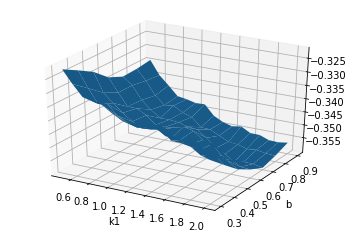

In [83]:
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(K1,B,U)
plt.xlabel('k1')
plt.ylabel('b')
plt.show()

In [88]:
def jm_obj(params):
  cfg = 'config.toml'
  # print('Building or loading index...')
  idx = metapy.index.make_inverted_index(cfg)
  # ranker = load_ranker(cfg)
  # ranker = metapy.index.OkapiBM25(k1, b, k3)

  ranker = metapy.index.JelinekMercer(params)
  ev = metapy.index.IREval(cfg)

  with open(cfg, 'r') as fin:
      cfg_d = pytoml.load(fin)

  query_cfg = cfg_d['query-runner']
  if query_cfg is None:
      print("query-runner table needed in {}".format(cfg))
      sys.exit(1)

  start_time = time.time()
  top_k = 10
  query_path = query_cfg.get('query-path', 'queries.txt')
  query_start = query_cfg.get('query-id-start', 0)

  query = metapy.index.Document()
  ndcg = 0.0
  num_queries = 0

  # print('Running queries')
  with open(query_path) as query_file:
      for query_num, line in enumerate(query_file):
          query.content(line.strip())
          results = ranker.score(idx, query, top_k)
          ndcg += ev.ndcg(results, query_start + query_num, top_k)
          num_queries+=1
  ndcg= ndcg / num_queries
          
  # print("NDCG@{}: {}".format(top_k, ndcg))
  # print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))  
  return -ndcg

In [108]:
jm_vals = []
p_vals = np.linspace(0, 1, 30)

for p in p_vals:
  jm_vals.append(jm_obj(p))

jm_vals = np.array(jm_vals)

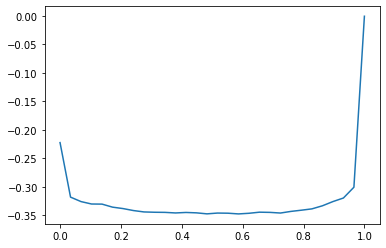

In [109]:
plt.plot(p_vals, jm_vals)
plt.show()

In [97]:
def dp_obj(params):
  cfg = 'config.toml'
  # print('Building or loading index...')
  idx = metapy.index.make_inverted_index(cfg)
  # ranker = load_ranker(cfg)
  # ranker = metapy.index.OkapiBM25(k1, b, k3)

  ranker = metapy.index.DirichletPrior(params)
  ev = metapy.index.IREval(cfg)

  with open(cfg, 'r') as fin:
      cfg_d = pytoml.load(fin)

  query_cfg = cfg_d['query-runner']
  if query_cfg is None:
      print("query-runner table needed in {}".format(cfg))
      sys.exit(1)

  start_time = time.time()
  top_k = 10
  query_path = query_cfg.get('query-path', 'queries.txt')
  query_start = query_cfg.get('query-id-start', 0)

  query = metapy.index.Document()
  ndcg = 0.0
  num_queries = 0

  # print('Running queries')
  with open(query_path) as query_file:
      for query_num, line in enumerate(query_file):
          query.content(line.strip())
          results = ranker.score(idx, query, top_k)
          ndcg += ev.ndcg(results, query_start + query_num, top_k)
          num_queries+=1
  ndcg= ndcg / num_queries
          
  # print("NDCG@{}: {}".format(top_k, ndcg))
  # print("Elapsed: {} seconds".format(round(time.time() - start_time, 4)))  
  return -ndcg

In [112]:
dp_vals = []
p_vals = np.linspace(10, 1250, 50)

for p in p_vals:
  dp_vals.append(dp_obj(p))

dp_vals = np.array(dp_vals)

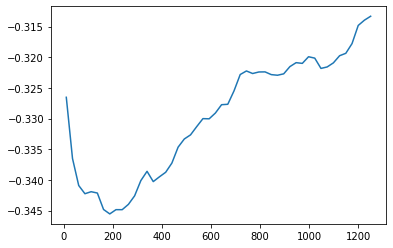

In [113]:
plt.plot(p_vals, dp_vals)
plt.show()

## Grading

You must beat the "baseline" on the leaderboard to get full credit, i.e. your "Overall Score" should be greater than the Overall Score of the baseline. The last column on the Leaderboard indicates whether you completed this requirement or not (1 or 0). 

The leaderboard also shows more details of the performance (NDCG@10). "Overall Score" is computed as 0.1* NDCG@10 on APNews + 0.3* NDCG@10 on Cranfield + 0.6* NDCG@10 on Faculty dataset.

## Bonus: Top ranked in Search Competition Leaderboard

Try to get a top position in the competition leaderboard. The higher your rank is, the more extra credit you will receive. The rank is based on "Overall Score".
Our grading formula for the competition is  max(0, 5-(Rank-1)/10) where Rank is the position of the student. This means that about 50 students will receive an extra credit greater than 0. Students with the same score will receive the same extra credit.

You will not immediately see the extra credit score on Coursera since it depends on your final rank in the leaderboard when the deadline is over. We will add your extra credit score on Coursera later.